# WAV2VEC2 Inference Decoding Notebook

Based on https://pytorch.org/tutorials/intermediate/speech_recognition_pipeline_tutorial.html

And 
https://pytorch.org/audio/main/tutorials/asr_inference_with_ctc_decoder_tutorial.html

Created audio for Mary Had a Little Lamb, and Tested Greedy and Beamsearch Decoding.  

<img src="images/decode_results.png" width="500" height="400">

# Setup

In [4]:
import os
import time

import IPython
import torch
import torchaudio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchaudio.models.decoder import ctc_decoder
from torchaudio.models.decoder import download_pretrained_files

from transformers import pipeline

torch.random.manual_seed(0)

print(f"PyTorch Version: {torch.__version__}, Pytorchaudio Version: {torchaudio.__version__}")

PyTorch Version: 2.2.1, Pytorchaudio Version: 2.2.1


In [5]:
# Create Pipeline
model_checkpoint="facebook/wav2vec2-large-960h-lv60-self"
asr_pipeline = pipeline("automatic-speech-recognition", model=model_checkpoint)
model = asr_pipeline.model
vocab = [label.lower() for label in asr_pipeline.tokenizer.vocab]
target_sampling_rate = asr_pipeline.feature_extractor.sampling_rate

Some weights of the model checkpoint at facebook/wav2vec2-large-960h-lv60-self were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.maske

# Decoders

In [6]:
class GreedyCTCDecoder(torch.nn.Module):
    """
    Summary: simple decoder using argmax to determine best character, 
             then remove duplicates per CTC's algorithm.
    
    Note: would be better to use CTC using maximumizing liklihood of sequence 
         (i.e. using adjacent logits to guess characters.) 
    """
    def __init__(self, vocab, pad=0):
        super().__init__()
        self.labels = vocab
        self.blank = pad

    def forward(self, emission: torch.Tensor):
        """Given a sequence emission over labels, get the best path
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          List[str]: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [int(i) for i in indices if i != self.blank]
        
        joined = "".join([self.labels[i] for i in indices])
        return joined.replace("|", " ").strip().split()
        
greedy_decoder = GreedyCTCDecoder(vocab)

In [7]:
files = download_pretrained_files("librispeech-4-gram")
LM_WEIGHT = 3.23
WORD_SCORE = -0.26

beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens='./tokens.txt',
    lm=files.lm,
    nbest=3,
    beam_size=1500,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
    blank_token='<pad>',
    unk_word='<unk>'
)

## Part 1: Mary Had a Little Lamb Spoken

In [8]:
SPEECH_FILE = "data/mary_had_a_little_lamb_spoken.wav"
actual_transcript = "mary had a little lamb little lamb little lamb mary had a little lamb her fleece was white as snow everywhere that mary went mary went mary went everywhere that mary went her lamb was sure to go"
actual_transcript = actual_transcript.split()
# Load Entire Song
if os.path.exists(SPEECH_FILE):
    data_waveform, data_sample_rate = torchaudio.load(SPEECH_FILE)
    print(f"File Sample Rate: {data_sample_rate}, Number of Samples: {data_waveform.shape}")
    waveform = torchaudio.functional.resample(data_waveform, data_sample_rate, target_sampling_rate)
    sample_rate = target_sampling_rate
    print(f"Target Sample Rate: {sample_rate}")
else:
    print('NO FILE HERE!')

chans, samples = waveform.size()
print(f"Number of Samples: {samples}")
print(f"Wavform is: {samples / sample_rate}s long.")
IPython.display.Audio(waveform,rate=sample_rate)

File Sample Rate: 44100, Number of Samples: torch.Size([1, 980870])
Target Sample Rate: 16000
Number of Samples: 355872
Wavform is: 22.242s long.


## Greedy Decoding Transcription
**Objective**: Execise the model with all audio data for Mary Had a L. <br>

In [9]:
# Performance on Greedy Decoding on 24s spoken song with lots of repitition.
start = time.time()
with torch.inference_mode():
    emission = model(waveform)
    greedy_result = greedy_decoder(emission[0][0,:,:])

finish = time.time()

# create transcript and WER
greedy_transcript = " ".join(greedy_result)
part1_greedy_wer = torchaudio.functional.edit_distance(actual_transcript, greedy_result) / len(actual_transcript)
    
print(f"Time to perform inference (with decoding): {finish-start:.1f} seconds.")
print(f"Song is {samples / sample_rate:.2f} seconds long.  {samples} samples long.")
print(f"Model Transcript: {greedy_transcript}\n") 
print(f"WER: {part1_greedy_wer:.3f}, Real Time Factor: {(samples / sample_rate)/(finish-start):.2f}")

Time to perform inference (with decoding): 2.8 seconds.
Song is 22.24 seconds long.  355872 samples long.
Model Transcript: mary had a little lamb little lamb little lamb mary had a little lamb her fleece was white as snow everywhere that mary went mary went mary went everywhere that mary wamp her lamb was sure to go

WER: 0.026, Real Time Factor: 7.85


## Beam Search Decoding Transcription
**Objective**: Execise the model with all audio data for Mary Had a L. <br>

In [10]:
start = time.time()
with torch.inference_mode():
    emission = model(waveform)
    beam_search_result = beam_search_decoder(emission[0])

finish = time.time()
beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()
part1_beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, beam_search_result[0][0].words) / len(actual_transcript)

print(f"Time to perform inference (with decoding): {finish-start:.1f} seconds.")
print(f"Song is {samples / sample_rate:.2f} seconds long.  {samples} samples long.")
print(f"Model Transcript: {beam_search_transcript}\n")
print(f"WER: {part1_beam_search_wer: .3f}, Real Time Factor: {(samples / sample_rate)/(finish-start):.2f}")

Time to perform inference (with decoding): 4.4 seconds.
Song is 22.24 seconds long.  355872 samples long.
Model Transcript: mary had a little lamb little lamb little lamb mary had a little lamb her fleece was white as snow everywhere that mary went mary went mary went everywhere that mary went the lamb was sure to go

WER:  0.026, Real Time Factor: 5.07


## Part 2: Mary Had a Little Lamb Song

In [11]:
SPEECH_FILE = "data/mary_had_a_little_lamb_song.wav"
actual_transcript = "mary had a little lamb little lamb little lamb mary had a little lamb her fleece was white as snow everywhere that mary went mary went mary went everywhere that mary went her lamb was sure to go"
actual_transcript = actual_transcript.split()
# Load Entire Song
if os.path.exists(SPEECH_FILE):
    data_waveform, data_sample_rate = torchaudio.load(SPEECH_FILE)
    print(f"File Sample Rate: {data_sample_rate}, Number of Samples: {data_waveform.shape}")
    waveform = torchaudio.functional.resample(data_waveform, data_sample_rate, target_sampling_rate)
    sample_rate = target_sampling_rate
    print(f"Target Sample Rate: {sample_rate}")
else:
    print('NO FILE HERE!')

chans, samples = waveform.size()
print(f"Number of Samples: {samples}")
print(f"Wavform is: {samples / sample_rate}s long.")
IPython.display.Audio(waveform,rate=sample_rate)

File Sample Rate: 44100, Number of Samples: torch.Size([1, 1012291])
Target Sample Rate: 16000
Number of Samples: 367272
Wavform is: 22.9545s long.


## Greedy Decoding Transcription
**Objective**: Execise the model with all audio data for Mary Had a L. <br>

In [12]:
# Performance on Greedy Decoding on 24s spoken song with lots of repitition.
start = time.time()
with torch.inference_mode():
    emission = model(waveform)
    greedy_result = greedy_decoder(emission[0][0,:,:])

finish = time.time()

# create transcript and WER
greedy_transcript = " ".join(greedy_result)
part2_greedy_wer = torchaudio.functional.edit_distance(actual_transcript, greedy_result) / len(actual_transcript)
    
print(f"Time to perform inference (with decoding): {finish-start:.1f} seconds.")
print(f"Song is {samples / sample_rate:.2f} seconds long.  {samples} samples long.")
print(f"Model Transcript: {greedy_transcript}\n") 
print(f"WER: {part2_greedy_wer:.3f}, Real Time Factor: {(samples / sample_rate)/(finish-start):.2f}")

Time to perform inference (with decoding): 2.9 seconds.
Song is 22.95 seconds long.  367272 samples long.
Model Transcript: mary had a little lamb little lamb little lamb mary had a little lamb her fleece was white as snow everywhere that mary went mary went mary went everywhere that mary went her lamb was sure to go

WER: 0.000, Real Time Factor: 7.84


## Beam Search Decoding Transcription
**Objective**: Execise the model with all audio data for Mary Had a L. <br>

In [13]:
start = time.time()
with torch.inference_mode():
    emission = model(waveform)
    beam_search_result = beam_search_decoder(emission[0])

finish = time.time()
beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()
part2_beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, beam_search_result[0][0].words) / len(actual_transcript)

print(f"Time to perform inference (with decoding): {finish-start:.1f} seconds.")
print(f"Song is {samples / sample_rate:.2f} seconds long.  {samples} samples long.")
print(f"Model Transcript: {beam_search_transcript}\n")
print(f"WER: {part2_beam_search_wer: .3f}, Real Time Factor: {(samples / sample_rate)/(finish-start):.2f}")

Time to perform inference (with decoding): 4.7 seconds.
Song is 22.95 seconds long.  367272 samples long.
Model Transcript: mary had a little lamb little lamb little lamb mary had a little lamb her fleece was white as snow everywhere that mary went mary went mary went everywhere that mary went the lamb was sure to go

WER:  0.026, Real Time Factor: 4.89


## Part 3: Mary Had a Little Lamb Metal Song!
Rock A-Bye Melodies: https://www.youtube.com/watch?v=ZYv8Ro3crP8

In [14]:
SPEECH_FILE = "data/mary_had_a_little_lamb_metal.wav"
actual_transcript = "mary had a little lamb her fleece was white as snow everywhere that mary went her lamb was sure to go"
actual_transcript = actual_transcript.split()
# Load Entire Song
if os.path.exists(SPEECH_FILE):
    data_waveform, data_sample_rate = torchaudio.load(SPEECH_FILE)
    print(f"File Sample Rate: {data_sample_rate}, Number of Samples: {data_waveform.shape}")
    waveform = torchaudio.functional.resample(data_waveform, data_sample_rate, target_sampling_rate)
    sample_rate = target_sampling_rate
    print(f"Target Sample Rate: {sample_rate}")
else:
    print('NO FILE HERE!')

chans, samples = waveform.size()
print(f"Number of Samples: {samples}")
print(f"Wavform is: {samples / sample_rate}s long.")
IPython.display.Audio(waveform,rate=sample_rate)

File Sample Rate: 48000, Number of Samples: torch.Size([2, 593884])
Target Sample Rate: 16000
Number of Samples: 197962
Wavform is: 12.372625s long.


## Greedy Decoding Transcription
**Objective**: Execise the model with all audio data for Mary Had a L. <br>

In [15]:
# Performance on Greedy Decoding on 24s spoken song with lots of repitition.
start = time.time()
with torch.inference_mode():
    emission = model(waveform)
    greedy_result = greedy_decoder(emission[0][0,:,:])

finish = time.time()

# create transcript and WER
greedy_transcript = " ".join(greedy_result)
part3_greedy_wer = torchaudio.functional.edit_distance(actual_transcript, greedy_result) / len(actual_transcript)
    
print(f"Time to perform inference (with decoding): {finish-start:.1f} seconds.")
print(f"Song is {samples / sample_rate:.2f} seconds long.  {samples} samples long.")
print(f"Model Transcript: {greedy_transcript}\n") 
print(f"WER: {part3_greedy_wer:.3f}, Real Time Factor: {(samples / sample_rate)/(finish-start):.2f}")

Time to perform inference (with decoding): 2.9 seconds.
Song is 12.37 seconds long.  197962 samples long.
Model Transcript: 

WER: 1.000, Real Time Factor: 4.22


## Beam Search Decoding Transcription
**Objective**: Execise the model with all audio data for Mary Had a L. <br>

In [16]:
start = time.time()
with torch.inference_mode():
    emission = model(waveform)
    beam_search_result = beam_search_decoder(emission[0])

finish = time.time()
beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()
part3_beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, beam_search_result[0][0].words) / len(actual_transcript)

print(f"Time to perform inference (with decoding): {finish-start:.1f} seconds.")
print(f"Song is {samples / sample_rate:.2f} seconds long.  {samples} samples long.")
print(f"Model Transcript: {beam_search_transcript}\n")
print(f"WER: {part3_beam_search_wer: .3f}, Real Time Factor: {(samples / sample_rate)/(finish-start):.2f}")

Time to perform inference (with decoding): 6.5 seconds.
Song is 12.37 seconds long.  197962 samples long.
Model Transcript: 

WER:  1.000, Real Time Factor: 1.91


# Results Summary

In [17]:
from tabulate import tabulate

col2 = [part1_greedy_wer, part1_beam_search_wer, part2_greedy_wer, part2_beam_search_wer, part3_greedy_wer, part3_beam_search_wer]
col1 = ['Part 1: Spoken Word','Part 1: Spoken Word','Part 2: Unaccompanied Singing','Part 2: Unaccompanied Singing','Part 3: Polyphonic','Part 3: Polyphonic']
col3 = ['Greedy','Beam Search', 'Greedy', 'Beam Search', 'Greedy', 'Beam Search']
df = pd.DataFrame({'Source': col1, 'Decoder': col3, 'WER': col2}).sort_values(by='WER')
print(tabulate(df, headers='keys', tablefmt='pipe', showindex=False))


| Source                        | Decoder     |       WER |
|:------------------------------|:------------|----------:|
| Part 2: Unaccompanied Singing | Greedy      | 0         |
| Part 1: Spoken Word           | Greedy      | 0.0263158 |
| Part 1: Spoken Word           | Beam Search | 0.0263158 |
| Part 2: Unaccompanied Singing | Beam Search | 0.0263158 |
| Part 3: Polyphonic            | Greedy      | 1         |
| Part 3: Polyphonic            | Beam Search | 1         |


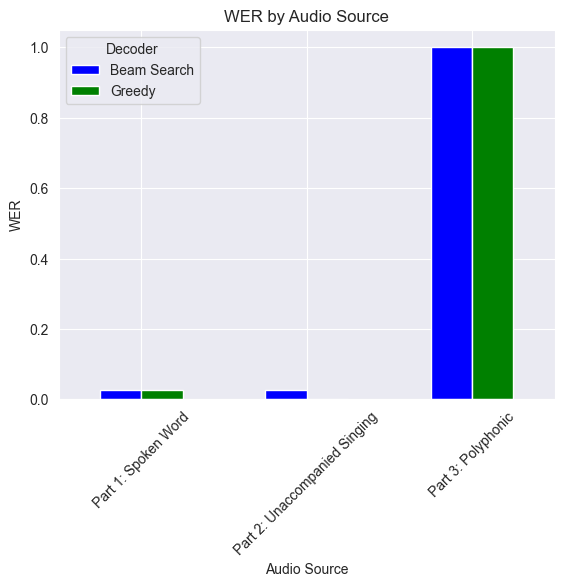

In [18]:
# Plot
import seaborn as sns

sns.set_style('darkgrid')
ax = df.pivot(index='Source', columns='Decoder', values='WER').plot.bar(color=['blue', 'green'])

# Customize plot
plt.xlabel('Audio Source')
plt.ylabel('WER')
plt.title('WER by Audio Source')
plt.xticks(rotation=45)
plt.legend(title='Decoder')